# 6장 연습문제

## 7.
문제: moons 데이터셋에 결정 트리를 훈련시키고 세밀하게 튜닝해보세요.

a. make_moons(n_samples=1000, noise=0.4)를 사용해 데이터셋을 생성합니다.

random_state=42를 지정하여 결과를 일정하게 만듭니다:

In [1]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

In [2]:
len(X)

10000

In [3]:
import matplotlib.pylab as plt 

In [4]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

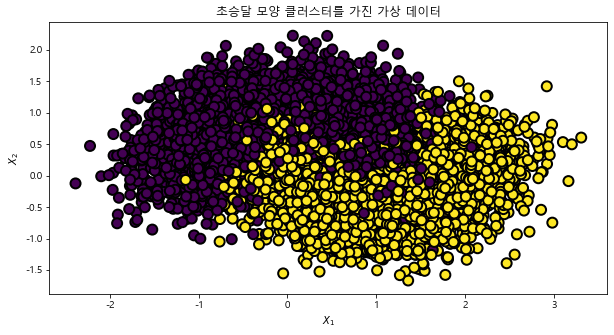

In [5]:
plt.figure(figsize=(10,5))
plt.title("초승달 모양 클러스터를 가진 가상 데이터")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100,
            edgecolor="k", linewidth=2)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

b. 이를 train_test_split()을 사용해 훈련 세트와 테스트 세트로 나눕니다

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

c. DecisionTreeClassifier의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행합니다(GridSearchCV를 사용하면 됩니다). 힌트: 여러 가지 max_leaf_nodes 값을 시도해보세요.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=3, n_jobs=-1, verbose=1)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 857 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    5.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
  

In [8]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

d. 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정합니다. 대략 85~87%의 정확도가 나올 것입니다.

기본적으로 GridSearchCV는 전체 훈련 세트로 찾은 최적의 모델을 다시 훈련시킵니다(refit=False로 지정해서 바꿀 수 있습니다). 그래서 별도로 작업할 필요가 없습니다. 모델의 정확도를 바로 평가할 수 있습니다:

In [9]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

## 8.
Exercise: 랜덤 포레스트를 만들어보세요.

a. 이전 연습문제에 이어서, 훈련 세트의 서브셋을 1,000개 생성합니다. 각각은 무작위로 선택된 100개의 샘플을 담고 있습니다. 힌트: 사이킷런의 ShuffleSplit을 사용할 수 있습니다.

In [17]:
from sklearn.model_selection import ShuffleSplit

n_trees = 5
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42) # ShuffleSplit 객체 생성 
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [21]:
len(mini_sets[0][1])

100


b. 앞에서 찾은 최적의 매개변수를 사용해 각 서브셋에 결정 트리를 훈련시킵니다. 테스트 세트로 이 1,000개의 결정 트리를 평가합니다. 더 작은 데이터셋에서 훈련되었기 때문에 이 결정 트리는 앞서 만든 결정 트리보다 성능이 떨어져 약8 0%의 정확도를 냅니다.

In [12]:
import numpy as np
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)


0.8054499999999999

c. 이제 마술을 부릴 차례입니다. 각 테스트 세트 샘플에 대해 1,000개의 결정 트리 예측을 만들고 다수로 나온 예측만 취합니다(사이파이의 mode() 함수를 사용할 수 있습니다). 그러면 테스트 세트에 대한 다수결 예측이 만들어집니다.

In [32]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [33]:
Y_pred[0][:200]

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0], dtype=uint8)

In [34]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)


d. 테스트 세트에서 이 예측을 평가합니다. 앞서 만든 모델보다 조금 높은(약 0.5~1.5% 정도) 정확도를 얻게 될 것입니다. 축하합니다. 랜덤 포레스트 분류기를 훈련시켰습니다!

In [13]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

In [43]:
 len(y_pred_majority_votes.reshape([-1]))

2000

In [41]:
y_pred_majority_votes

array([[1, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [42]:
len(y_pred_majority_votes)

1